In [3]:
###Drifter Field Data Analysis

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.io.img_tiles import StamenTerrain

In [29]:
filename = '80010505'

YSIfilename = 'May6YSIData'

fullname = filename+'.csv'

YSIfullname = YSIfilename+ '.csv'

filepath = os.path.join('D:', fullname) # PJB: changed from "'D', fullname" to "'Data', fullname"

YSIfilepath = os.path.join('D:', YSIfullname) # PJB: ditto


df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None, date_format = '%m/%d/%Y %H:%M:%S')

YSIdf = pd.read_csv(YSIfilepath, parse_dates = [[0, 1]], header = None, encoding = 'utf-16', skiprows = 17)
df.columns = ['time', 'elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'altitude', 'speed', 'angle', 'pH', 'Temperature (C)', 'DO (mg/L)', 'Conductivity (uS/cm)']

YSIdf.columns = ['Time',	'Time (Fract. Sec)',	'Site Name',	'Chlorophyll RFU',	'Cond µS/cm',	'Depth m',	'fDOM QSU',	'fDOM RFU',	'nLF Cond µS/cm',	'ODO % sat',	'ODO % local',	'ODO mg/L',	'Pressure psi a',	'Sal psu',	'SpCond µS/cm',	'TAL PE RFU',	'TDS mg/L',	'Turbidity FNU',	'TSS mg/L',	'pH',	'pH mV',	'Temp °C',	'Vertical Position m',	'GPS Latitude °',	'GPS Longitude °',	'Altitude m',	'Battery V',	'Cable Pwr V',	'Barometer mmHg']

df = df.truncate(before= 31, copy = None)


df.head()



,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,altitude,speed,angle,pH,Temperature (C),DO (mg/L),Conductivity (uS/cm)
31,6/4/2025 16:21:25.000,64,3409.36279,N,7751.41895,W,6.6,0.17,0.0,6.59,27.82,11.76,0.0
32,6/4/2025 16:21:27.000,66,3409.36279,N,7751.41895,W,5.9,0.20,0.0,6.59,27.82,11.75,0.0
33,6/4/2025 16:21:29.000,68,3409.36279,N,7751.41895,W,5.5,0.14,0.0,6.58,27.83,11.75,0.0
34,6/4/2025 16:21:31.000,70,3409.36279,N,7751.41846,W,5.1,0.08,0.0,6.58,27.83,11.74,0.0
35,6/4/2025 16:21:33.000,72,3409.36304,N,7751.41846,W,4.8,0.08,0.0,6.57,27.83,11.73,0.0


In [31]:
def lat_convert(lat_badfmt):
    """Convert latitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lat_badfmt = str(lat_badfmt)
        lat_DD = int(float(lat_badfmt) / 100)  # Extract degrees
        lat_MM = float(lat_badfmt) - lat_DD * 100  # Extract minutes
        return lat_DD + lat_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

def lon_convert(lon_badfmt):
    """Convert longitude from DDDMM.MMMM format to decimal degrees."""
    try:
        lon_badfmt = str(lon_badfmt)
        lon_DD = int(float(lon_badfmt) / 100)  # Extract degrees
        lon_MM = float(lon_badfmt) - lon_DD * 100  # Extract minutes
        return lon_DD + lon_MM / 60  # Convert to decimal degrees
    except ValueError:
        return None  # Return None if conversion fails

# Apply conversions
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# Fix South (negative latitudes)
df.loc[df['N or S'] == 'S', 'lat'] *= -1

# Fix West (negative longitudes)
df.loc[df['E or W'] == 'W', 'lon'] *= -1

# Check output
df.head()


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,altitude,speed,angle,pH,Temperature (C),DO (mg/L),Conductivity (uS/cm),lat,lon
31,6/4/2025 16:21:25.000,64,3409.36279,N,7751.41895,W,6.6,0.17,0.0,6.59,27.82,11.76,0.0,34.156047,-77.856983
32,6/4/2025 16:21:27.000,66,3409.36279,N,7751.41895,W,5.9,0.20,0.0,6.59,27.82,11.75,0.0,34.156047,-77.856983
33,6/4/2025 16:21:29.000,68,3409.36279,N,7751.41895,W,5.5,0.14,0.0,6.58,27.83,11.75,0.0,34.156047,-77.856983
34,6/4/2025 16:21:31.000,70,3409.36279,N,7751.41846,W,5.1,0.08,0.0,6.58,27.83,11.74,0.0,34.156047,-77.856974
35,6/4/2025 16:21:33.000,72,3409.36304,N,7751.41846,W,4.8,0.08,0.0,6.57,27.83,11.73,0.0,34.156051,-77.856974


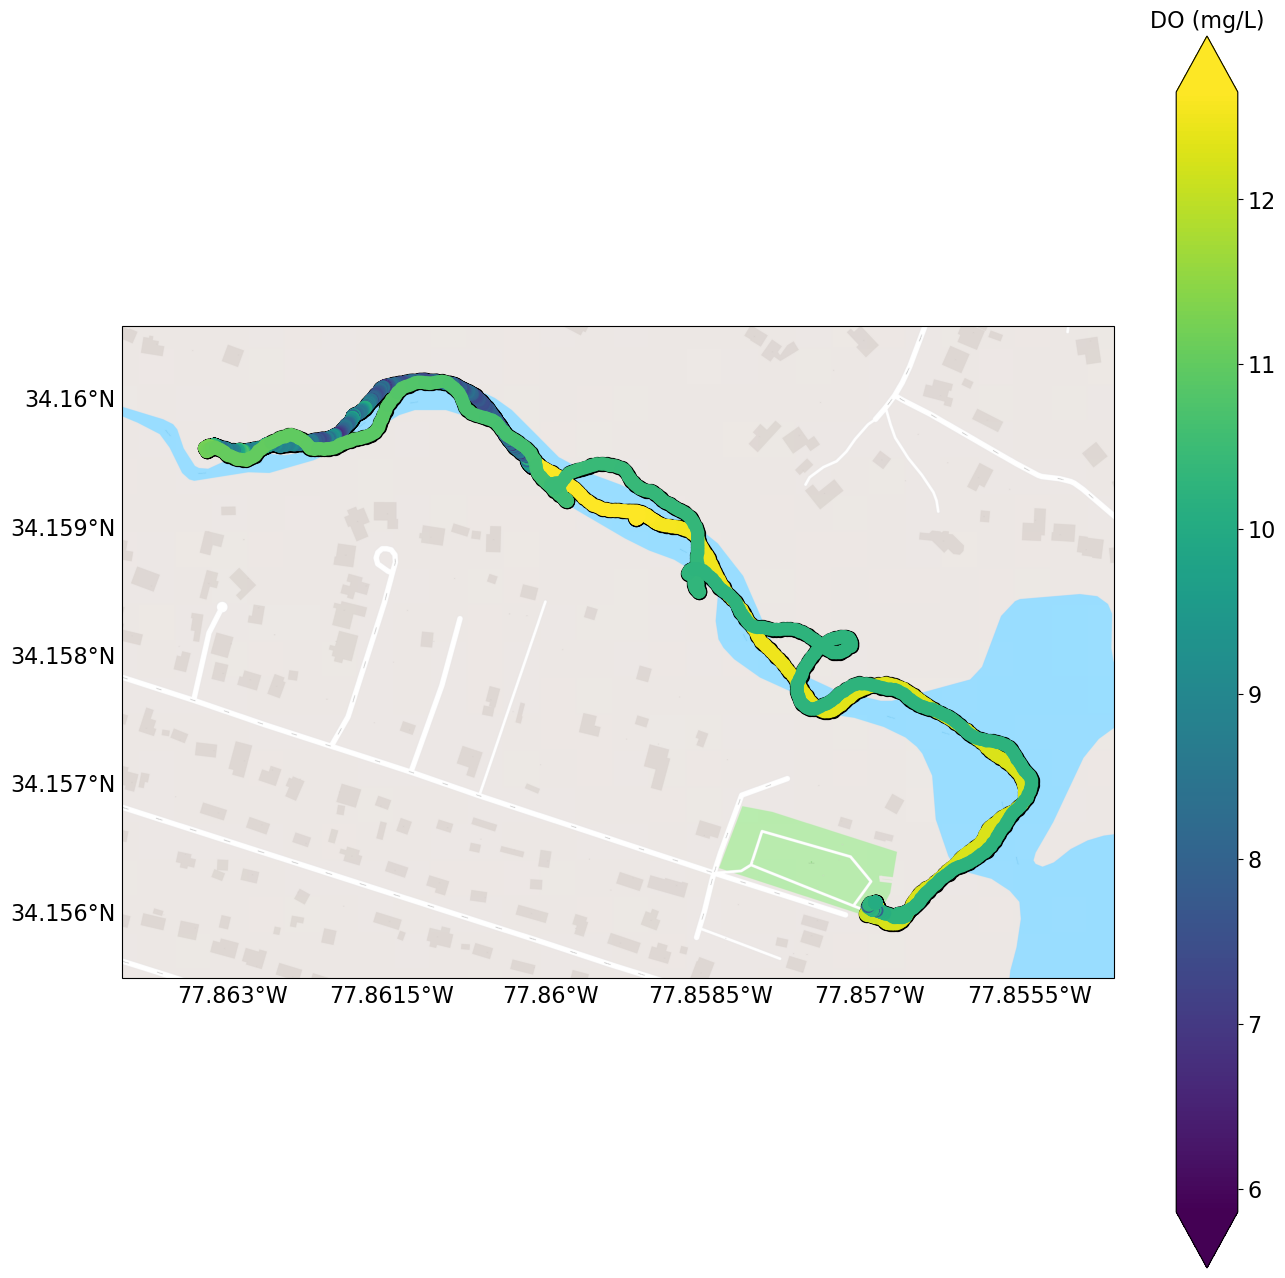

In [33]:
## Mapbox
mapbox_token = os.environ.get('mapbox_access_token')
map_id = 'streets-v12'
base_layer_mapbox = cimgt.MapboxTiles(mapbox_token, map_id=map_id)
tile_zoom_mapbox = 20
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

# Get desired variable
var_name = 'DO (mg/L)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

figname = filename + var_name+'.png'
figpath = os.path.join('Figs', figname)
# plt.savefig(figpath, dpi = 300) # (un)comment depending on preference for saving figure locally


In [ ]:
tiler = StamenTerrain()
mercator = tiler.crs

var_name = 'DO (mg/L)' # selected from columns above
plot_var = df[var_name]
lat = df['lat']
lon = df['lon']

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=mercator)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=ccrs.PlateCaree)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}


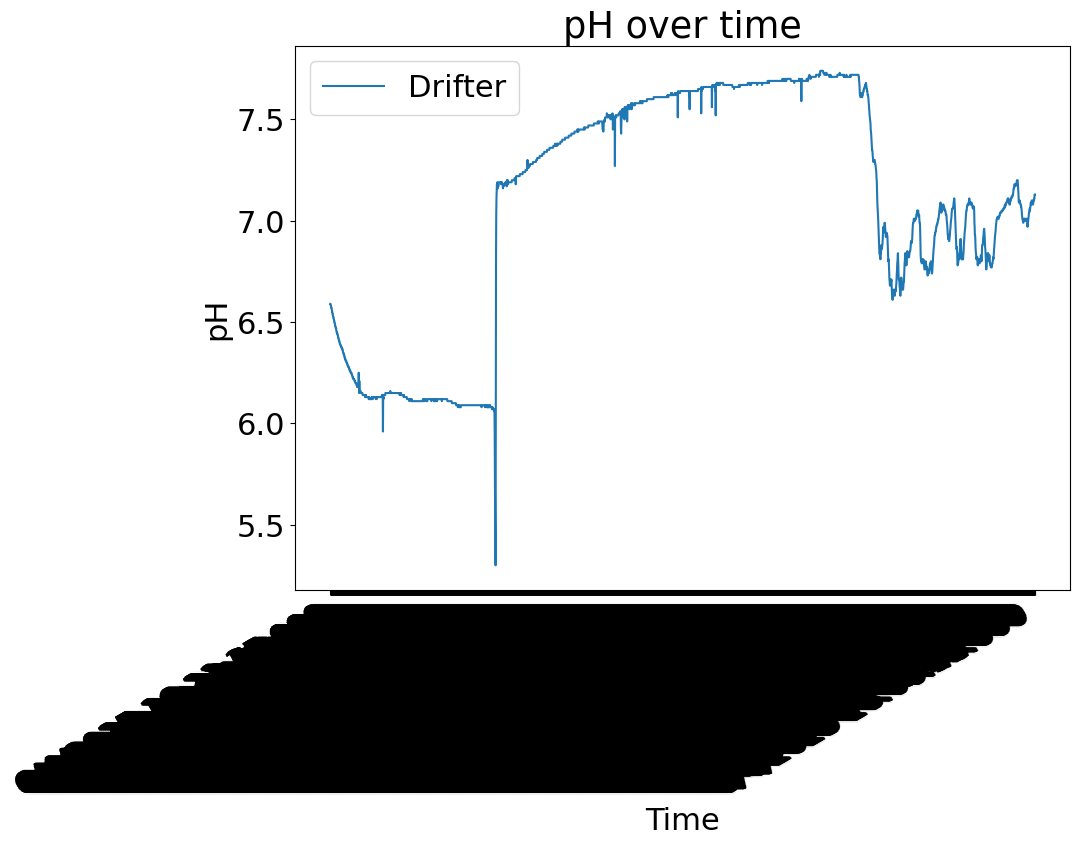

In [35]:
#time = df['time']  # No longer needed
ph = df['pH']       # Keep this
#YSItime = YSIdf['Time']
#YSIph = YSIdf['pH']
#hours_to_add = 5
#YSItime = YSItime + pd.Timedelta(hours= hours_to_add)

# Directly modify the 'time' column in df
#df.loc[0:11533, 'time'] = pd.to_datetime(df.loc[0:11533, 'time']) + pd.Timedelta(-480243, "h")

time = df['time'] #create time after the modification

#time_in_need_of_adj = time.loc[0:11534]
#time_adj = pd.to_datetime(time_in_need_of_adj) + pd.Timedelta(-480243, "h")
#time_corr = time
#time_corr.loc[0:11534] = time_adj
#Drifter_hours_to_subract = 1
#Years_to_subract= 55
#months_to_add= 2
#time = pd.to_datetime(time) + pd.Timedelta(-480243, "h")

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access

plt.plot(time,ph, label = "Drifter")
#plt.plot(YSItime,YSIph, label = "YSI")
plt.title('pH over time')
plt.xlabel('Time')
plt.ylabel('pH')
axs.legend()
fig.autofmt_xdate()

# PJB: Stephen, add legend to graph

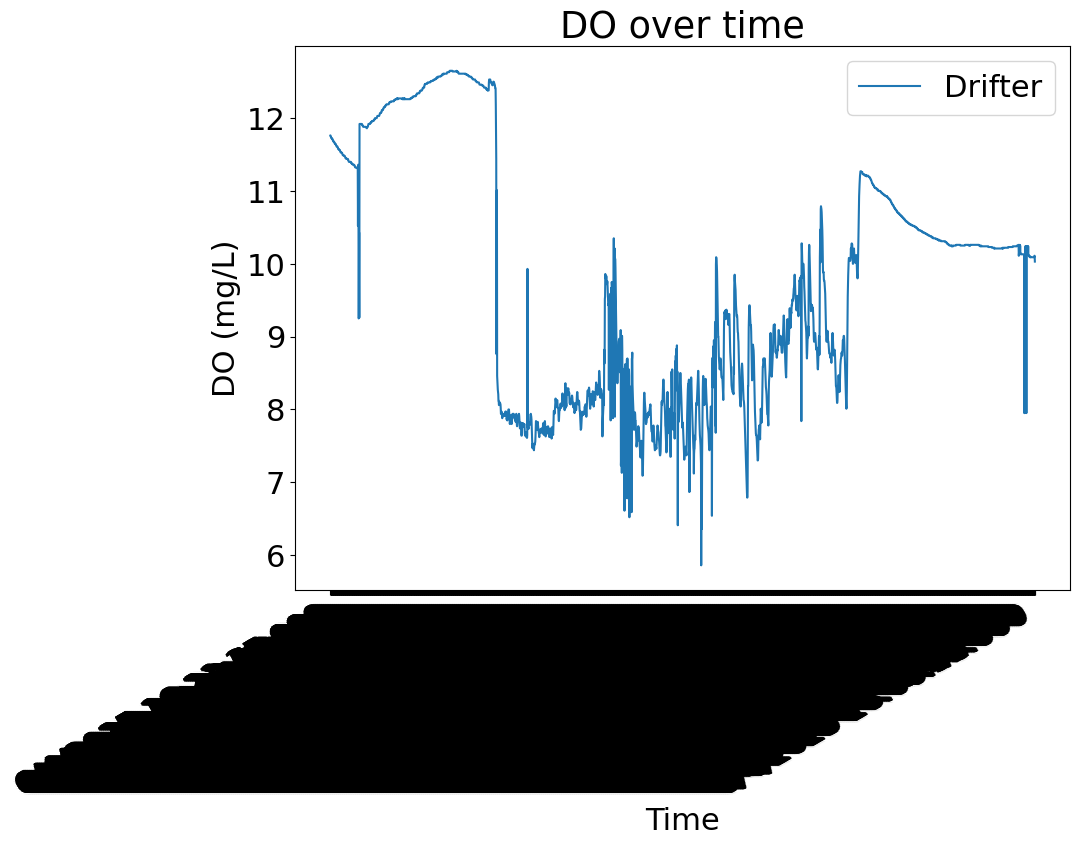

In [37]:
DO = df['DO (mg/L)']  #Use +5.9 as a one point calibration correction for the Drifter (DO(salt) = DO * k * S(ppt)
#YSIDO = YSIdf['ODO mg/L'] 

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,DO, label = 'Drifter')
#plt.plot(YSItime, YSIDO, label = 'YSI EXO2s')
plt.title('DO over time')
plt.xlabel('Time')
plt.ylabel('DO (mg/L)')
axs.legend()
fig.autofmt_xdate()

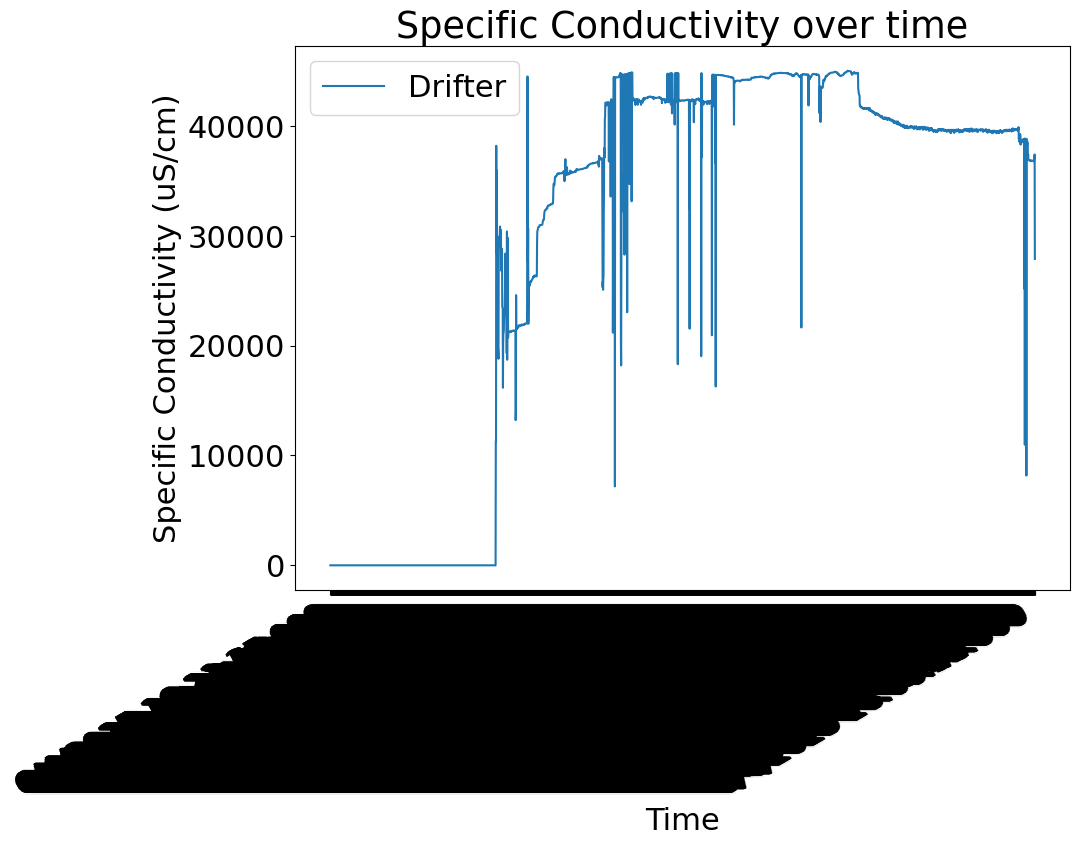

In [38]:
spcond = df['Conductivity (uS/cm)'] #point calibration for drifter
#YSIspcond = YSIdf['SpCond µS/cm']

plt.rcParams.update({'font.size':22}) #font size
fig, axs = plt.subplots(figsize = (10,8)) # PJB: explicitly create graph objects for subsequent access
plt.plot(time,spcond, label = 'Drifter')
#plt.plot(YSItime,YSIspcond, label = 'YSI EXO2s')
plt.title('Specific Conductivity over time')
plt.xlabel('Time')
plt.ylabel('Specific Conductivity (uS/cm)')
axs.legend()
fig.autofmt_xdate()

In [ ]:
df['time'].iloc[0]

In [ ]:
df['time'].iloc[-1]